In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import os
import torch
import joblib
import numpy as np

# 自定义模块
from TransformerModel import TimeSeriesTransformer
from LSTMModel import TimeSeriesLSTM
from Blender import MLPBlender
from Util import create_sequences, sample_dataset, plot_metric, plot_multiple_curves, grid_search, safe_inverse_transform, split_time_series

# 其他库
from torch.utils.data import random_split, TensorDataset
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [33]:
# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [85]:
# 准备数据
df_complete = pd.read_csv ('../TockFormerData\SPY_2020-01-01_2025-05-03_60m.csv')

# 先把数据分成3份再create sequence，这样scale才不会泄漏
df_train, df_val, df_test = split_time_series(df_complete, 0.9, 0.05, 0.05)

In [76]:
target_cols = ['open', 'high', 'low', 'close']
seq_length = 32

# 创建序列
X_train, y_train, scaler, target_indices = create_sequences(df_train, seq_length=seq_length, target_cols=target_cols, scale=True)
X_val, y_val, _, _ = create_sequences(df_val, seq_length=seq_length, target_cols=target_cols, scaler=scaler)
X_test, y_test, _, _ = create_sequences(df_test, seq_length=seq_length, target_cols=target_cols, scaler=scaler)

数据被缩放
数据被缩放
数据被缩放


In [77]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [78]:
# 检查数据集大小
print (f"Train dataset size: {len(train_dataset)}")
print (f"Test dataset size: {len(test_dataset)}")
print (f"Val dataset size: {len(val_dataset)}")

Train dataset size: 20255
Test dataset size: 503
Val dataset size: 501


In [52]:
# 定义网格搜索 时序Transformer，找最好的超参数
# 固定的初始化参数
init_args = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

# 架构超参数空间
param_grid = {
    'model_dim': [64, 128],
    'num_heads': [2, 4],
    'num_layers': [2, 3]
}

best_params, best_score = grid_search (
    TimeSeriesTransformer,
    init_args,
    sample_dataset(train_dataset, 0.1),
    param_grid,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params)
print ('Best avg CV MSE:', best_score)

Testing architecture params: {'model_dim': 64, 'num_heads': 2, 'num_layers': 2}
=== Fold 1/3 ===
Using device: cuda


KeyboardInterrupt: 

In [69]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_tock = {
 'model_dim': 64,
 'num_heads': 2,
 'num_layers': 2,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1
 }


best_params_tock

{'model_dim': 64,
 'num_heads': 2,
 'num_layers': 2,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1}

Using device: cuda
Epoch 1: Bad batch threshold reached at batch 337. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 388. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 471. Reshuffling training data.
Epoch 1/50, Train Loss: 0.008530
Epoch 1/50, Val MSEs: [1487.0755615234375, 619.3511962890625, 1045.8515625, 1383.595947265625], R²: [-13.321392059326172, -5.111117362976074, -8.769098281860352, -12.267317771911621]
Epoch 2: Bad batch threshold reached at batch 79. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 129. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 274. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 324. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 374. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 424. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 518. Reshuffling t

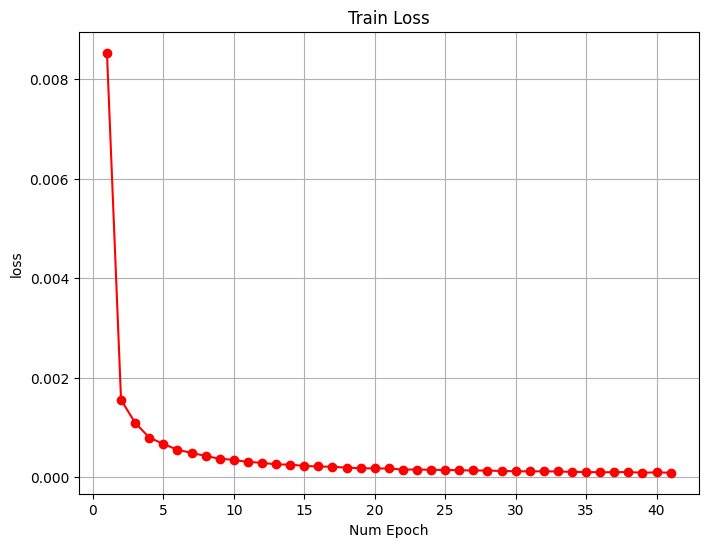

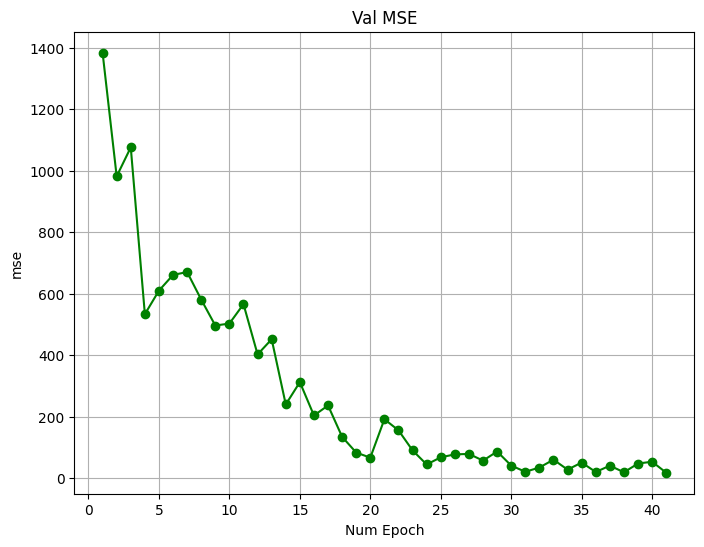

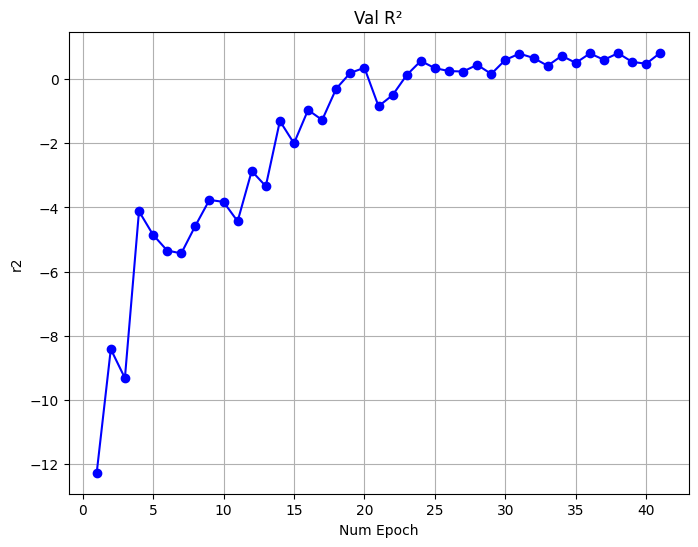

In [70]:
# 如果表现优异，对 tock 进行 train
tock = TimeSeriesTransformer (**best_params_tock)
train_loss, mse_list_train, r2_list_train = tock.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [86.61579895019531, 109.82662200927734, 93.31412506103516, 95.07740020751953]
测试集 R²:  [0.9044904112815857, 0.8739062547683716, 0.9010846614837646, 0.895051121711731]


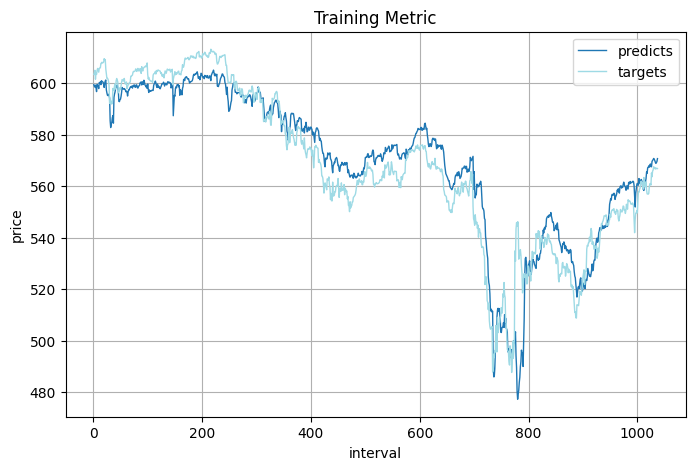

In [71]:
# 对test 进行测试
mse_list_tock, r2_list_tock, preds_tock, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)


print ("测试集 MSE: ", mse_list_tock)
print ("测试集 R²: ", r2_list_tock)

curve_dict = {}
curve_dict['predicts'] = preds_tock[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 网格搜索 LSTM 超参数

init_args_lstm = {
    'input_dim': 49,
    'output_dim': 4,
    'dropout': 0.1
}

param_grid_lstm = {
    'hidden_dim': [64, 128],
    'num_layers': [2, 3],
}

best_params_lstm, best_score_lstm = grid_search (
    TimeSeriesLSTM,
    init_args_lstm,
    sample_dataset(train_dataset, 0.1),
    param_grid=param_grid_lstm,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params_lstm)
print ('Best avg CV MSE:', best_score_lstm)

In [40]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_lstm = {
 'hidden_dim': 128,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 2,
 'dropout': 0.1
 }

best_params_lstm

{'hidden_dim': 128,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 2,
 'dropout': 0.1}

Using device: cuda
Epoch 1/100, Loss: 0.042545
Epoch 1/100, Val MSEs: [66.12865447998047, 80.37419891357422, 100.98223114013672, 41.62614822387695], R²: [0.7932835817337036, 0.7392768859863281, 0.6953840255737305, 0.8706010580062866]
Epoch 2: reshuffling after 59 bad batches
Epoch 2: reshuffling after 155 bad batches
Epoch 2: reshuffling after 205 bad batches
Epoch 2: reshuffling after 255 bad batches
Epoch 2: reshuffling after 305 bad batches
Epoch 2/100, Loss: 0.000227
Epoch 2/100, Val MSEs: [34.19496536254883, 24.184412002563477, 51.87200164794922, 32.73255920410156], R²: [0.8931074738502502, 0.9215490221977234, 0.8435265421867371, 0.8982476592063904]
Epoch 3: reshuffling after 59 bad batches
Epoch 3: reshuffling after 109 bad batches
Epoch 3: reshuffling after 163 bad batches
Epoch 3: reshuffling after 213 bad batches
Epoch 3: reshuffling after 263 bad batches
Epoch 3: reshuffling after 313 bad batches
Epoch 3/100, Loss: 0.000161
Epoch 3/100, Val MSEs: [24.565082550048828, 19.94580

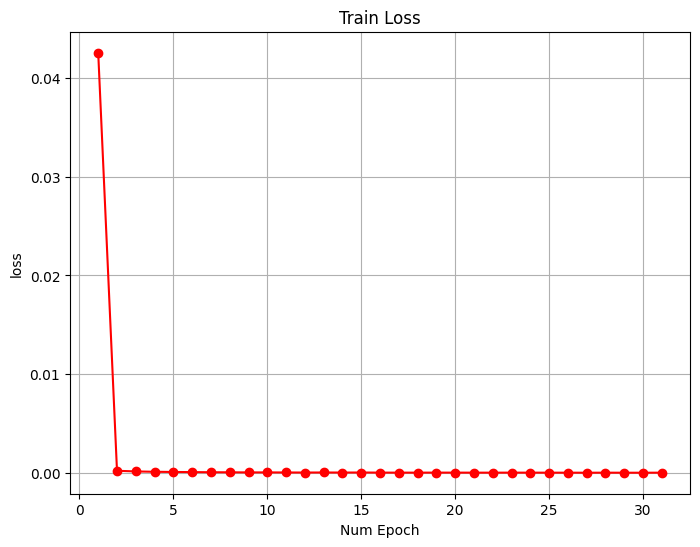

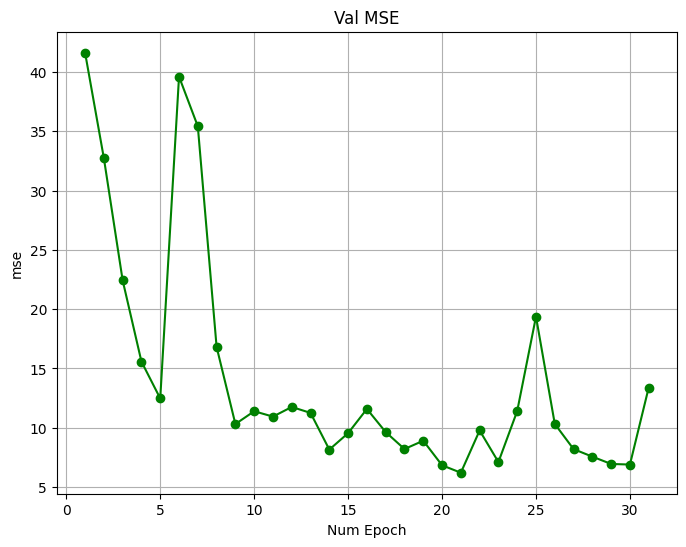

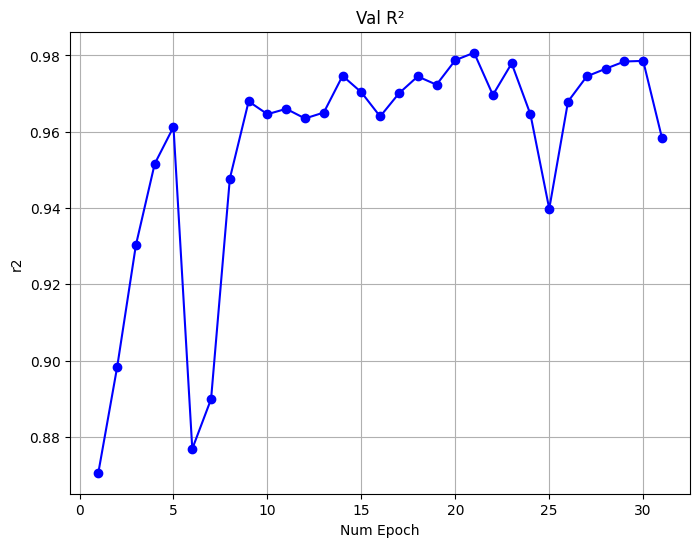

In [82]:
# 如果表现优异，对 lstm 进行 train
lstm = TimeSeriesLSTM (**best_params_lstm)
train_loss, mse_list_train, r2_list_train = lstm.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=100,
    batch_size=64,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [39.23271560668945, 50.042415618896484, 32.99658203125, 45.10012435913086]
测试集 R²:  [0.9122325778007507, 0.8797368407249451, 0.9315292835235596, 0.8985743522644043]


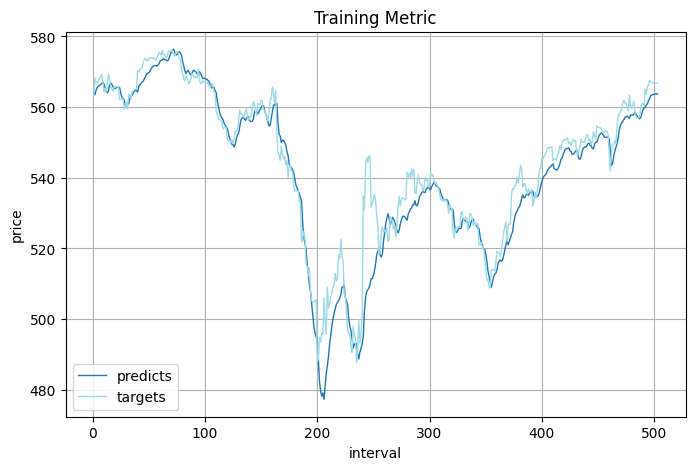

In [83]:
mse_list_lstm, r2_list_lstm, preds_lstm, targets = lstm.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

print ("测试集 MSE: ", mse_list_lstm)
print ("测试集 R²: ", r2_list_lstm)

curve_dict = {}
curve_dict['predicts'] = preds_lstm[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 准备数据集
# X_train = train_dataset.tensors[0]
# y_train = train_dataset.tensors[1]
# X_val = val_dataset.tensors[0]
# y_val = val_dataset.tensors[1]
# X_test = test_dataset.tensors[0]
# y_test = test_dataset.tensors[1]


In [79]:
# 训练 线形模型
ridge = Ridge (alpha=1.0)
ridge.fit (X_train.reshape(X_train.shape[0], -1), y_train.numpy())

Ridge()

验证集 R²: 0.9949, 测试集R²:0.9848
测试集 MSE:  [2.403107976777263, 8.095365869663551, 5.8568980197068505, 10.642501953941183]


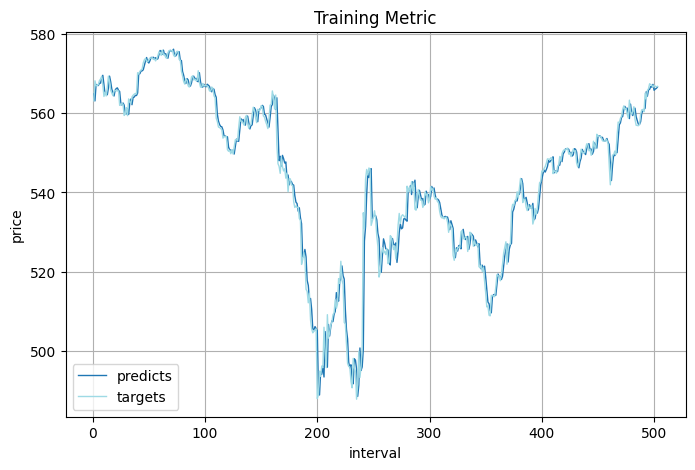

In [84]:
# 检测分数
score_val = ridge.score (X_val.reshape(X_val.shape[0], -1), y_val)
score_test = ridge.score (X_test.reshape(X_test.shape[0], -1), y_test)
print (f"验证集 R²: {score_val:.4f}, 测试集R²:{score_test:.4f}")



preds_rg = ridge.predict (X_test.reshape(X_test.shape[0], -1))
preds_rg = safe_inverse_transform (preds_rg, scaler, target_indices)

print ("测试集 MSE: ", [mean_squared_error(targets[:, i], preds_rg[:, i]) for i in range(preds_rg.shape[1])])

curve_dict = {}
curve_dict['predicts'] = preds_rg[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [20]:
# 训练 XGBoost 模型
import xgboost as xgb


# 3. 定义基模型——XGBRegressor（开启 GPU 加速）
xgb_base = xgb.XGBRegressor(
    tree_method='gpu_hist',      # GPU 上的直方图算法
    predictor='gpu_predictor',   # GPU 预测
    gpu_id=0,                    # 指定 GPU 卡，若只有一张卡则写 0
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1
)

# 4. 包装为多输出回归器
xgbst_mlt = MultiOutputRegressor(xgb_base)

# 5. 训练
xgbst_mlt.fit(X_train.reshape(X_train.shape[0], -1), y_train)

c:\Users\hinye\miniconda3\envs\TockFormer\lib\site-packages\xgboost\training.py:183: UserWarning: [15:38:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hinye\miniconda3\envs\TockFormer\lib\site-packages\xgboost\training.py:183: UserWarning: [15:38:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


c:\Users\hinye\miniconda3\envs\TockFormer\lib\site-packages\xgboost\training.py:183: UserWarning: [15:38:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hinye\miniconda3\envs\TockFormer\lib\site-packages\xgboost\training.py:183: UserWarning: [15:38:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hinye\miniconda3\envs\TockFormer\lib\site-packages\xgboost\training.py:183: UserWarning: [15:38:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist",

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            gpu_id=0, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None, ...))

c:\Users\hinye\miniconda3\envs\TockFormer\lib\site-packages\xgboost\core.py:2676: UserWarning: [15:39:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


验证集 R²: -1.3261, 测试集 R²: 0.8034
测试集 MSE:  [170.873291015625, 179.75222778320312, 177.39080810546875, 184.5056915283203]


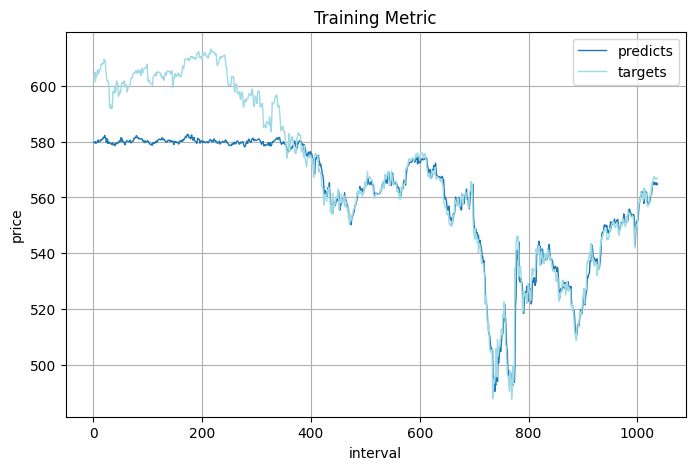

In [21]:
# —— R² 评估 —— 
# MultiOutputRegressor 自带 .score 会返回多输出的 R²（平均）
score_val = xgbst_mlt.score(X_val.reshape(X_val.shape[0], -1), y_val)
score_test = xgbst_mlt.score(X_test.reshape(X_test.shape[0], -1), y_test)
print(f"验证集 R²: {score_val:.4f}, 测试集 R²: {score_test:.4f}")


preds_xgbst = xgbst_mlt.predict(X_test.reshape(X_test.shape[0], -1))
preds_xgbst = safe_inverse_transform (preds_xgbst, scaler, target_indices)

print ("测试集 MSE: ", [mean_squared_error(targets[:, i], preds_xgbst[:, i]) for i in range(preds_xgbst.shape[1])])

curve_dict = {}
curve_dict['predicts'] = preds_xgbst[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')


In [22]:
# 整理 Blender 数据
X_val_tock = tock.predict_model (X_val, scaler=None)
X_val_lstm = lstm.predict_model (X_val, scaler=None)

X_val_ridge = ridge.predict (X_val.reshape(X_val.shape[0], -1))

X_val_xgbst = xgbst_mlt.predict(X_val.reshape(X_val.shape[0], -1))

X_val_blender = np.concatenate ((
    # X_val_tock,
    # X_val_lstm,
    X_val_ridge,
    X_val_xgbst
    ), axis=1)
X_val_blender[:1], y_val[:1]

(array([[0.99135157, 0.99024629, 0.9925505 , 0.99178324, 0.98620951,
         0.9864803 , 0.98682284, 0.98703855]]),
 tensor([[0.9894, 0.9875, 0.9889, 0.9871]]))

In [23]:
# 先用一个简单的线性模型进行 blender
ridge_blender = Ridge (alpha=1)
ridge_blender.fit (X_val_blender, y_val.numpy())

Ridge(alpha=1)

In [24]:
# Blender 预测 测试集
X_test_tock = tock.predict_model (X_test)
X_test_lstm = lstm.predict_model (X_test)
X_test_ridge = ridge.predict (X_test.reshape(X_test.shape[0], -1))
X_test_xgbst = xgbst_mlt.predict(X_test.reshape(X_test.shape[0], -1))

X_test_blender = np.concatenate ((
    # X_test_tock,
    # X_test_lstm,
    X_test_ridge,
    X_test_xgbst
    ), axis=1)
X_test_blender[:1], y_test[:1]

(array([[1.05053821, 1.05023507, 1.05161237, 1.05063739, 0.98512673,
         0.98321778, 0.98541498, 0.9841339 ]]),
 tensor([[1.0492, 1.0478, 1.0487, 1.0489]]))

Test R²: 0.9357
测试集 MSE:  [55.08023727304096, 52.57034632948612, 64.49241451414375, 61.321215183093386]


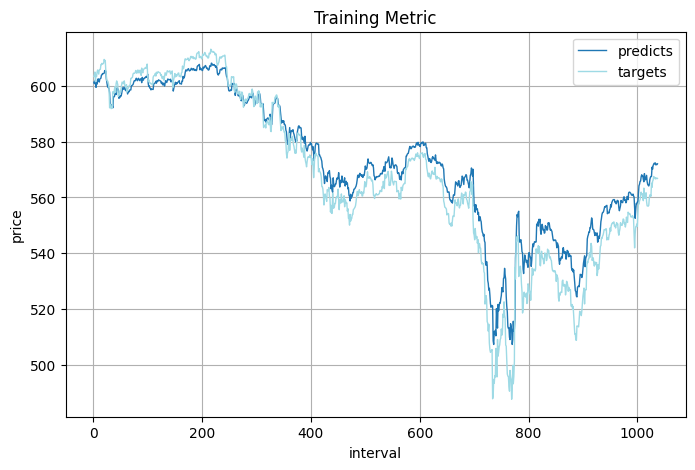

In [25]:
score = ridge_blender.score (X_test_blender, y_test)
print (f"Test R²: {score:.4f}")


preds_blender = ridge_blender.predict (X_test_blender)
preds_blender = safe_inverse_transform (preds_blender, scaler, target_indices)
print ("测试集 MSE: ", [mean_squared_error(targets[:, i], preds_blender[:, i]) for i in range(preds_blender.shape[1])])

curve_dict = {}
curve_dict['predicts'] = preds_blender[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

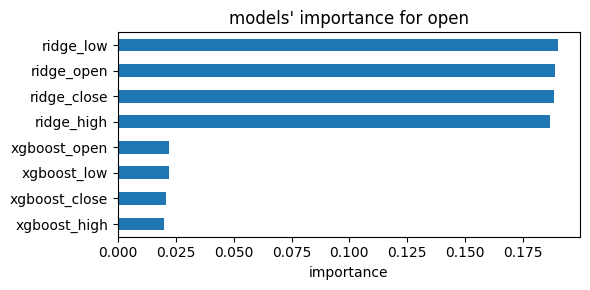

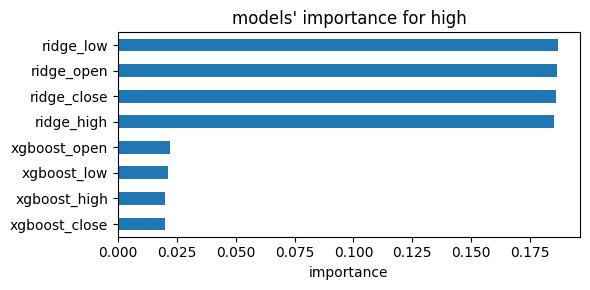

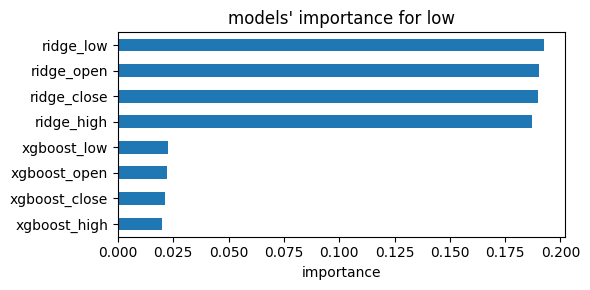

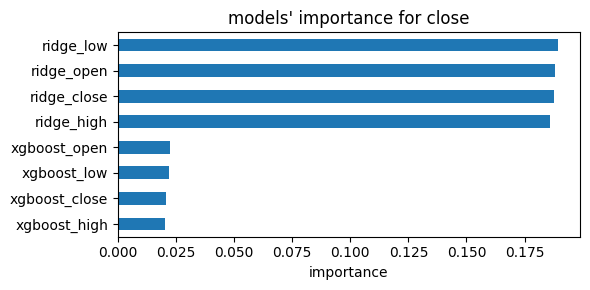

In [ ]:
import matplotlib.pyplot as plt


model_names  = [
    # 'tock',
    # 'lstm',
    'ridge',
    'xgboost']
target_names = ['open','high','low','close']

# 特征列名对应顺序：第一组是 tock_open,tock_high,...,tock_close，
# 然后是 lstm_open,...，以此类推
cols = [f"{m}_{t}" for m in model_names for t in target_names]

# coef_ 的形状是 (4,16)
df_coefs = pd.DataFrame(
    ridge_blender.coef_,
    index=target_names,
    columns=cols
)

# 对每个目标分别画图
for tgt in target_names:
    coefs = df_coefs.loc[tgt]
    # 绝对值排序
    coefs = coefs.abs().sort_values(ascending=True)
    plt.figure(figsize=(6,3))
    coefs.plot(kind='barh')
    plt.title(f"models' importance for {tgt}")
    plt.xlabel("importance")
    plt.tight_layout()
    plt.show()

In [29]:
model_out   = "../TockFormerModels/BaseModels"
scaler_out  = "../TockFormerModels/Scalers"
blender_out = "../TockFormerModels/Blenders"

# 确保目录存在（创建到最末级）
os.makedirs(model_out,   exist_ok=True)
os.makedirs(scaler_out,  exist_ok=True)
os.makedirs(blender_out, exist_ok=True)


In [30]:
from datetime import datetime

date_str = datetime.now().strftime("%Y%m%d")

# 3. 保存 PyTorch 模型
torch.save(tock.state_dict(), f"{model_out}/Transformer_{date_str}.pth")
torch.save(lstm.state_dict(), f"{model_out}/LSTM_{date_str}.pth")

# 4. 保存 sklearn 模型
joblib.dump(ridge,     f"{model_out}/Ridge_{date_str}.pkl")
joblib.dump(xgbst_mlt, f"{model_out}/XGBST_MultiOutput_{date_str}.pkl")

# 5. 保存 Scaler
joblib.dump(scaler,    f"{scaler_out}/StandardScaler_{date_str}.pkl")

# 6. 保存 Blender（Ridge）
joblib.dump(ridge_blender, f"{blender_out}/RidgeBlender_{date_str}.pkl")

print("模型保存成功！")

模型保存成功！
